In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import model_selection
import scipy.stats
%matplotlib inline

In [76]:
crime_2 = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
                 )

In [77]:
#cleaning, removing header rows
crime_2.columns = crime_2.iloc[3]
crime_2.droprow = crime_2.drop(crime_2.index[0:4], inplace=True)

#rename columns
crime_2.columns = ['city','population','violent_crime','murder','rape_revised',
                 'rape_legacy','robbery','agg_assault','property_crime','burglary','larceny_theft',
                 'motor_theft','arson3']
#remove na from pop
crime_2.dropna(subset = ['population'], inplace=True)
#drop rape (revised def 1)
crime_2.drop(['rape_revised'],axis=1,inplace=True)

# Change the Arson null values to 0. 
crime_2['arson3'].fillna(0, inplace=True)


In [81]:
#remove , and conver to float (for desired columns)
crime_2 = crime_2.replace(',','',regex=True)
crime_2.iloc[:,1:] = crime_2.iloc[:,1:].apply(lambda x: pd.to_numeric(x))
crime_2 = crime_2.reset_index(drop=True)

#creating indicators
crime_2['robbery_ind'] = crime_2.robbery.where(crime_2.robbery ==0,1)
crime_2['murder_ind'] = crime_2.murder.where(crime_2.murder ==0,1)
crime_2['rape_ind'] = crime_2.rape_legacy.where(crime_2.rape_legacy ==0,1)
crime_2['assault_ind'] = crime_2.agg_assault.where(crime_2.agg_assault ==0,1)
crime_2['motor_ind'] = crime_2.motor_theft.where(crime_2.motor_theft ==0,1)

In [82]:
#now keeping only desired columns (adding larcenyt and burglary as continuous)
crime_reg_2 = crime_2.loc[:, ['property_crime','population', 'burglary','larceny_theft', 'murder_ind',
                              'robbery_ind','rape_ind','assault_ind', 'motor_ind']]

#reset index
crime_reg_2 = crime_reg_2.reset_index(drop=True)

In [83]:
crime_reg_2.describe()

,property_crime,population,burglary,larceny_theft,murder_ind,robbery_ind,rape_ind,assault_ind,motor_ind
count,348.000000,3.480000e+02,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,792.606322,4.003763e+04,119.683908,637.017241,0.140805,0.600575,0.413793,0.810345,0.732759
std,7659.724746,4.500374e+05,924.948789,6346.054451,0.348321,0.490486,0.493221,0.392593,0.443157
min,0.000000,5.260000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.500000,3.003000e+03,6.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,112.500000,7.233500e+03,17.500000,94.000000,0.000000,1.000000,0.000000,1.000000,1.000000
75%,341.000000,1.842750e+04,51.250000,287.250000,0.000000,1.000000,1.000000,1.000000,1.000000
max,141971.000000,8.396126e+06,16606.000000,117931.000000,1.000000,1.000000,1.000000,1.000000,1.000000


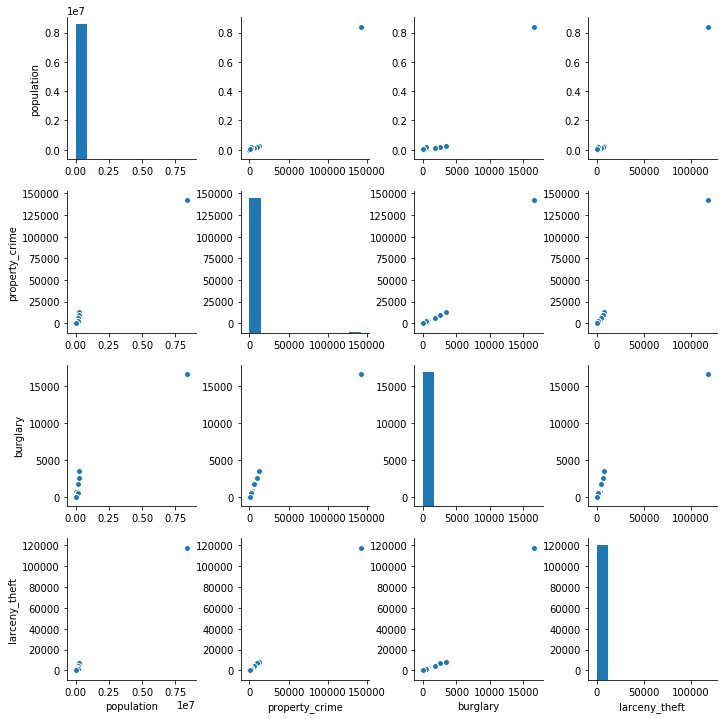

In [84]:
#pairplot, exluding the binary indicators
sns.pairplot(crime_reg_2[['population','property_crime','burglary','larceny_theft']])

In [85]:
#looking at stats and pairpolots, there are clearly extreme data points in my continuous variables.
#winzorize my data, as while the values in the variables could be extreme, they could also be likely given the range in cities
#nd pops
for column in crime_reg_2.loc[:,'property_crime':'murder_ind']:
    crime_reg_2[column] = scipy.stats.mstats.winsorize(crime_reg_2[column],limits=[0.05,0.05])

In [86]:
#add pop sq now
crime_reg_2['pop_sq'] =crime_reg_2['population'] **2

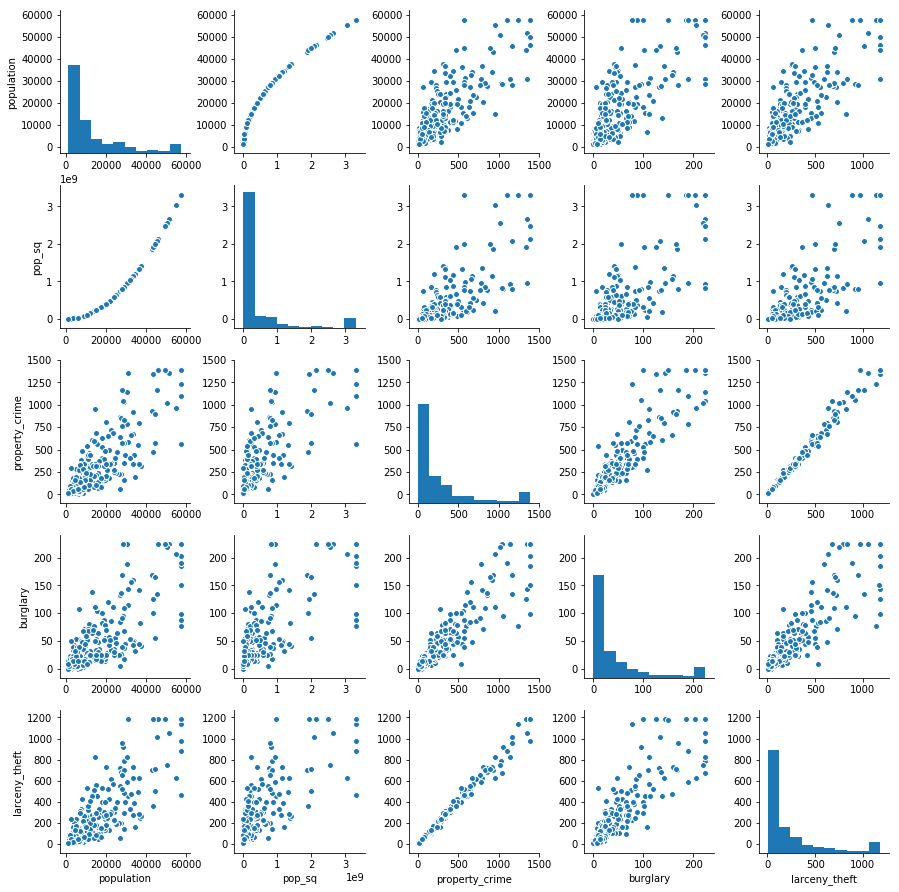

In [87]:
sns.pairplot(crime_reg_2[['population','pop_sq','property_crime','burglary','larceny_theft']])

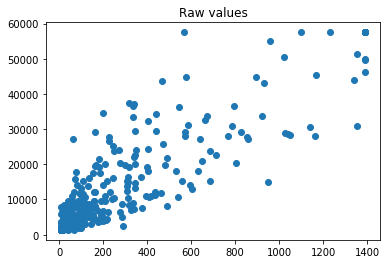

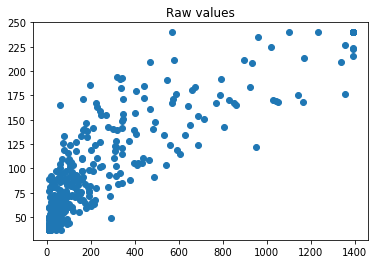

In [88]:
plt.scatter(crime_reg_2['property_crime'], crime_reg_2['population'])
plt.title('Raw values')
plt.show()


crime_reg_2['sqrt_pop'] = np.sqrt(crime_reg_2['population'])

plt.scatter(crime_reg_2['property_crime'], crime_reg_2['sqrt_pop'])
plt.title('Raw values')
plt.show()

In [89]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = crime_reg_2[['sqrt_pop', 'pop_sq','burglary','larceny_theft', 'murder_ind',
                              'robbery_ind','rape_ind','assault_ind', 'motor_ind']]
Y = crime_reg_2['property_crime']

regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))


Coefficients: 
 [  7.25704177e-02  -1.23755519e-10   1.14835905e+00   9.83374963e-01
  -1.01994924e+00  -3.52736489e-03   1.32900637e+00  -1.40997181e+00
   1.67157968e+00]

Intercept: 
 -3.8781942816

R-squared:
0.997956957154


In [90]:
data = X
target = Y


from sklearn.model_selection import train_test_split

#these data_train, etc are different than what defined above
data_train, data_test, target_train, target_test = model_selection.train_test_split(
   data, target, test_size=0.30, random_state=42)  
# # Fit our model to the data.
regr.fit(data_train, target_train)

# Classify, storing the result in a new variable.
test_pred = regr.predict(data_test)
train_pred = regr.predict(data_train)

print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print('The R^2 value for train set: ',format(regr.score(data_train,target_train)))
print('The R^2 value for test set: ',format(regr.score(data_test,target_test)))


Training Coefficients: 
 [  8.22284225e-02  -5.51132682e-09   1.21210505e+00   9.82054860e-01
  -4.58701292e-01  -5.30683606e-01  -1.40524570e-01  -1.63254403e+00
   1.19756982e+00]

Training Intercept: 
 -4.21636803734

Training R-squared:
The R^2 value for train set:  0.9979237391091016
The R^2 value for test set:  0.9978748723315328


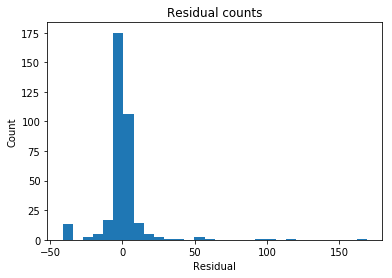

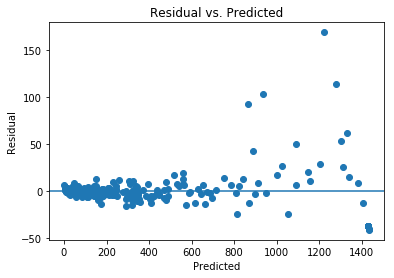

In [91]:
# Extract predicted values.
predicted = regr.predict(X)
actual = crime_reg_2['property_crime']

# Calculate residuals
residual = actual - predicted

# Histogram of residuals
plt.hist(residual,bins=30)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim()
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [92]:

from IPython.display import display
correlation_matrix = X.corr()
display(correlation_matrix)

,sqrt_pop,pop_sq,burglary,larceny_theft,murder_ind,robbery_ind,rape_ind,assault_ind,motor_ind
sqrt_pop,1.000000,0.870328,0.820055,0.857042,0.543158,0.554665,0.556501,0.375432,0.443680
pop_sq,0.870328,1.000000,0.830305,0.871133,0.563179,0.366363,0.437306,0.229617,0.282917
burglary,0.820055,0.830305,1.000000,0.918194,0.595177,0.476917,0.568770,0.311612,0.344758
larceny_theft,0.857042,0.871133,0.918194,1.000000,0.564809,0.497788,0.559026,0.307996,0.355001
murder_ind,0.543158,0.563179,0.595177,0.564809,1.000000,0.313271,0.381186,0.195844,0.225805
robbery_ind,0.554665,0.366363,0.476917,0.497788,0.313271,1.000000,0.470749,0.428592,0.448838
rape_ind,0.556501,0.437306,0.568770,0.559026,0.381186,0.470749,1.000000,0.302276,0.283244
assault_ind,0.375432,0.229617,0.311612,0.307996,0.195844,0.428592,0.302276,1.000000,0.403539
motor_ind,0.443680,0.282917,0.344758,0.355001,0.225805,0.448838,0.283244,0.403539,1.000000


In [93]:

#I am going to create a new feature, for the highest correlated features
#feature for highest correlated variables (Runs and Hits)
means = crime_reg_2[['sqrt_pop','pop_sq','burglary','larceny_theft']].mean(axis=0)
stds = crime_reg_2[['sqrt_pop','pop_sq','burglary','larceny_theft']].std(axis=0)
crime_reg_2['corr_feat'] = ((crime_reg_2[['sqrt_pop','pop_sq','burglary','larceny_theft']]-means)/stds).mean(axis=1)

In [94]:
#rerun model
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = crime_reg_2[['corr_feat', 'murder_ind','robbery_ind','rape_ind','assault_ind', 'motor_ind']]
Y = crime_reg_2['property_crime']

regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))


Coefficients: 
 [ 380.21679209  -11.00130907   14.46534893   26.05522266   -7.4110004
  -10.94931086]

Intercept: 
 276.600087753

R-squared:
0.944709366326


In [95]:
data = X
target = Y


from sklearn.model_selection import train_test_split

#these data_train, etc are different than what defined above
data_train, data_test, target_train, target_test = model_selection.train_test_split(
   data, target, test_size=0.30, random_state=42)  
# # Fit our model to the data.
regr.fit(data_train, target_train)

# Classify, storing the result in a new variable.
test_pred = regr.predict(data_test)
train_pred = regr.predict(data_train)

print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print('The R^2 value for train set: ',format(regr.score(data_train,target_train)))
print('The R^2 value for test set: ',format(regr.score(data_test,target_test)))


Training Coefficients: 
 [ 374.88171977   -3.55925168    9.27719992   36.48649143   -1.46160344
  -13.24198637]

Training Intercept: 
 275.281249406

Training R-squared:
The R^2 value for train set:  0.9480897310920421
The R^2 value for test set:  0.9365314013400714


Ok, test and train R^2 are close again. Let's look at predicted values.

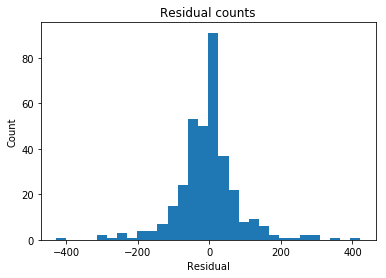

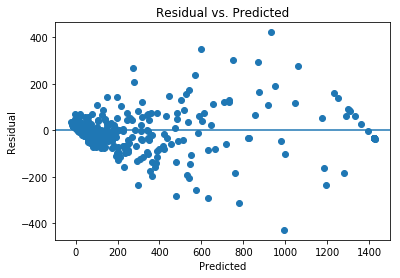

In [96]:
# Extract predicted values.
predicted = regr.predict(X)
actual = crime_reg_2['property_crime']

# Calculate residuals
residual = actual - predicted

# Histogram of residuals
plt.hist(residual,bins=30)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim()
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [97]:
from IPython.display import display
correlation_matrix = X.corr()
display(correlation_matrix)

,corr_feat,murder_ind,robbery_ind,rape_ind,assault_ind,motor_ind
corr_feat,1.000000,0.598600,0.500716,0.560375,0.323466,0.376741
murder_ind,0.598600,1.000000,0.313271,0.381186,0.195844,0.225805
robbery_ind,0.500716,0.313271,1.000000,0.470749,0.428592,0.448838
rape_ind,0.560375,0.381186,0.470749,1.000000,0.302276,0.283244
assault_ind,0.323466,0.195844,0.428592,0.302276,1.000000,0.403539
motor_ind,0.376741,0.225805,0.448838,0.283244,0.403539,1.000000


## Recreated using statsmodles

In [98]:
linear_formula = 'property_crime ~ corr_feat+murder_ind+robbery_ind+rape_ind+assault_ind+motor_ind'
# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=crime_reg_2).fit()

In [99]:
lm.params

Intercept      276.600088
corr_feat      380.216792
murder_ind     -11.001309
robbery_ind     14.465349
rape_ind        26.055223
assault_ind     -7.411000
motor_ind      -10.949311
dtype: float64

In [101]:
lm.pvalues

Intercept       3.806377e-62
corr_feat      2.994762e-161
murder_ind      5.232858e-01
robbery_ind     2.533061e-01
rape_ind        3.384088e-02
assault_ind     5.994764e-01
motor_ind       3.899110e-01
dtype: float64

In [102]:
# features do not have significant p-values. there is likely no effect from these features./

In [103]:
lm.rsquared

0.94470936632596247

In [104]:
#I am going to try running this again with pop_sq, sqrt_pop, burlgary and larceny
linear_formula2 = 'property_crime ~ pop_sq+sqrt_pop+burglary+larceny_theft+murder_ind+robbery_ind+rape_ind+assault_ind+motor_ind'
# Fit the model to our data using the formula.
lm2 = smf.ols(formula=linear_formula2, data=crime_reg_2).fit()

In [105]:
lm2.params

Intercept       -3.878194e+00
pop_sq          -1.237555e-10
sqrt_pop         7.257042e-02
burglary         1.148359e+00
larceny_theft    9.833750e-01
murder_ind      -1.019949e+00
robbery_ind     -3.527365e-03
rape_ind         1.329006e+00
assault_ind     -1.409972e+00
motor_ind        1.671580e+00
dtype: float64

In [106]:
lm2.pvalues

Intercept         1.975967e-01
pop_sq            9.662673e-01
sqrt_pop          8.526693e-02
burglary          1.173446e-88
larceny_theft    1.006612e-266
murder_ind        7.617098e-01
robbery_ind       9.989009e-01
rape_ind          5.873135e-01
assault_ind       6.081815e-01
motor_ind         5.064573e-01
dtype: float64

In [107]:
# Burglarly and larceny_theft are only features with significant p-values.

In [108]:
lm2.rsquared

0.99795695715381516

## Validating My Model With Another Dataset

In [118]:
crime_pa = pd.read_csv("pennsylvania.csv" )

In [119]:
crime_pa.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,PENNSYLVANIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3,NaN
4,"Abington Township, Lackawanna County","1,750",1,0,0,NaN,0,1,14,4,10,0,0,NaN


In [120]:
#cleaning, removing header rows
crime_pa.columns = crime_pa.iloc[3]
crime_pa.droprow = crime_pa.drop(crime_pa.index[0:4], inplace=True)

#rename columns
crime_pa.columns = ['city','population','violent_crime','murder','rape_revised',
                 'rape_legacy','robbery','agg_assault','property_crime','burglary','larceny_theft',
                 'motor_theft','arson3','unnamed']

In [121]:

#remove na from pop
crime_pa.dropna(subset = ['population'], inplace=True)
#drop rape (revised def 2) and unnamed
crime_pa.drop(['rape_legacy'],axis=1,inplace=True)
crime_pa.drop(['unnamed'],axis=1,inplace=True)

# # Change the Arson null values to 0. 
crime_pa['arson3'].fillna(0, inplace=True)

In [123]:
#remove , and conver to float (for desired columns)
crime_pa = crime_pa.replace(',','',regex=True)
crime_pa.iloc[:,1:] = crime_pa.iloc[:,1:].apply(lambda x: pd.to_numeric(x))
crime_pa = crime_pa.reset_index(drop=True)

#creating indicators
crime_pa['robbery_ind'] = crime_pa.robbery.where(crime_pa.robbery ==0,1)
crime_pa['murder_ind'] = crime_pa.murder.where(crime_pa.murder ==0,1)
crime_pa['rape_ind'] = crime_pa.rape_revised.where(crime_pa.rape_revised ==0,1)
crime_pa['assault_ind'] = crime_pa.agg_assault.where(crime_pa.agg_assault ==0,1)
crime_pa['motor_ind'] = crime_pa.motor_theft.where(crime_pa.motor_theft ==0,1)

In [124]:
#now keeping only desired columns 
crime_reg_pa = crime_pa.loc[:, ['property_crime','population', 'burglary','larceny_theft', 'murder_ind',
                              'robbery_ind','rape_ind','assault_ind', 'motor_ind']]

#reset index
crime_reg_pa = crime_reg_pa.reset_index(drop=True)

In [125]:
crime_reg_pa.describe()

,property_crime,population,burglary,larceny_theft,murder_ind,robbery_ind,rape_ind,assault_ind,motor_ind
count,853.000000,8.530000e+02,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000
mean,242.760844,1.076485e+04,44.302462,184.899179,0.111372,0.490035,0.405627,0.801876,0.682298
std,1884.982159,5.512654e+04,372.300831,1316.937843,0.314776,0.500194,0.491301,0.398820,0.465856
min,0.000000,1.980000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,2.403000e+03,4.000000,16.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,68.000000,4.626000e+03,11.000000,55.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,171.000000,1.014000e+04,25.000000,143.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,53452.000000,1.553153e+06,10408.000000,37253.000000,1.000000,1.000000,1.000000,1.000000,1.000000


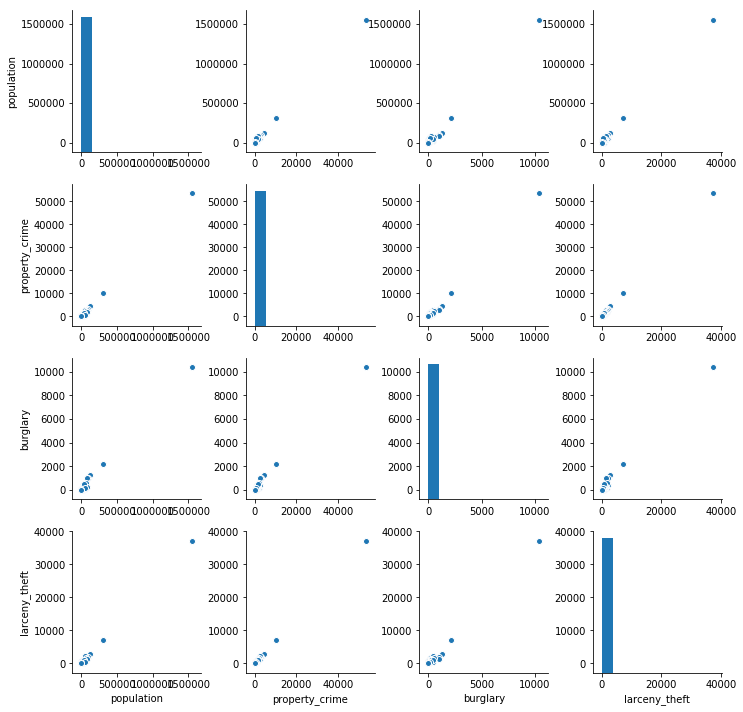

In [126]:
#pairplot, exluding the binary indicators
sns.pairplot(crime_reg_pa[['population','property_crime','burglary','larceny_theft']])

In [127]:
# extreme datapoints in my continuous variables. winsorize
for column in crime_reg_pa.loc[:,'property_crime':'murder_ind']:
    crime_reg_pa[column] = scipy.stats.mstats.winsorize(crime_reg_pa[column],limits=[0.05,0.05])

In [128]:
#add pop sq now
crime_reg_pa['pop_sq'] =crime_reg_pa['population'] **2

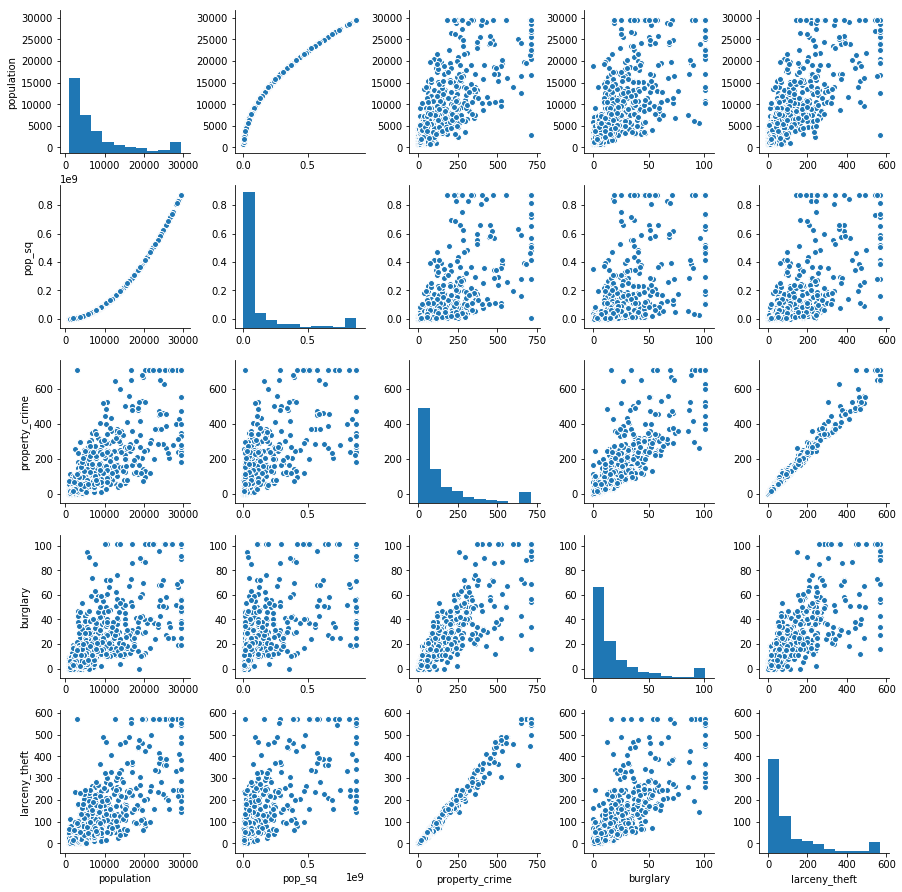

In [129]:
sns.pairplot(crime_reg_pa[['population','pop_sq','property_crime','burglary','larceny_theft']])

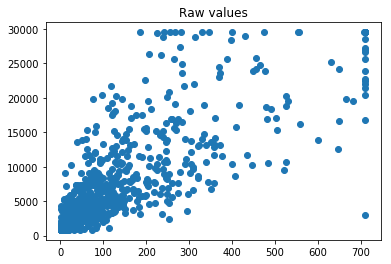

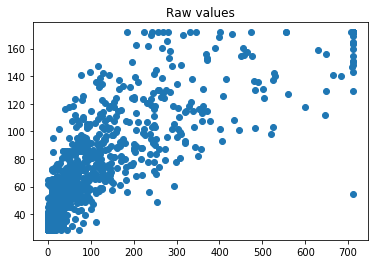

In [130]:
plt.scatter(crime_reg_pa['property_crime'], crime_reg_pa['population'])
plt.title('Raw values')
plt.show()


crime_reg_pa['sqrt_pop'] = np.sqrt(crime_reg_pa['population'])

plt.scatter(crime_reg_pa['property_crime'], crime_reg_pa['sqrt_pop'])
plt.title('Raw values')
plt.show()

## Fit and predict

In [132]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

X = crime_reg_pa[['sqrt_pop', 'pop_sq','burglary','larceny_theft', 'murder_ind',
                              'robbery_ind','rape_ind','assault_ind', 'motor_ind']]
Y = crime_reg_pa['property_crime']

regr.fit(X,Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X,Y))


Coefficients: 
 [ -1.02463482e-01   8.38125027e-09   1.21270642e+00   1.05528312e+00
   3.72095179e+00  -1.19093562e+00  -2.00136337e+00  -8.77088961e-01
   6.95906592e-01]

Intercept: 
 3.95249825548

R-squared:
0.996752332414


In [133]:
data = X
target = Y

from sklearn.model_selection import train_test_split

# these data_train, etc are different from what is define above
data_train, data_test, target_train, target_test = model_selection.train_test_split(
data, target, test_size=0.30, random_state=42)
# # Fit our model to the data.
regr.fit(data_train,target_train)

print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print('The R^2 value for the train set: ', format(regr.score(data_train,target_train)))
print('The R^2 value for the test set: ', format(regr.score(data_test, target_test)))


Training Coefficients: 
 [ -1.05510683e-01   3.32324799e-09   1.26126514e+00   1.05111231e+00
   3.40706859e+00  -1.28720634e+00  -1.62152388e+00  -7.72946088e-01
   5.27654913e-01]

Training Intercept: 
 4.03694377052

Training R-squared:
The R^2 value for the train set:  0.9973309920366752
The R^2 value for the test set:  0.9949570987187341


The R^2 for my train and test sets are close and high. Check the predicted values.

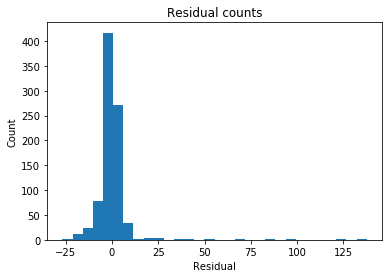

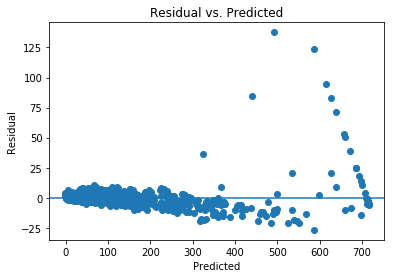

In [134]:
# Extract predicted values.
predicted = regr.predict(X)
actual = crime_reg_pa['property_crime']

# Calculate residuals
residual = actual - predicted

# Histogram of residuals
plt.hist(residual,bins=30)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim()
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [135]:
from IPython.display import display
correlation_matrix = X.corr()
display(correlation_matrix)

,sqrt_pop,pop_sq,burglary,larceny_theft,murder_ind,robbery_ind,rape_ind,assault_ind,motor_ind
sqrt_pop,1.000000,0.880475,0.765701,0.812446,0.386858,0.532586,0.515945,0.396645,0.478942
pop_sq,0.880475,1.000000,0.747543,0.813335,0.398210,0.405160,0.411640,0.238272,0.318712
burglary,0.765701,0.747543,1.000000,0.865826,0.504433,0.515042,0.516892,0.329143,0.423981
larceny_theft,0.812446,0.813335,0.865826,1.000000,0.451819,0.534764,0.504128,0.320885,0.421040
murder_ind,0.386858,0.398210,0.504433,0.451819,1.000000,0.234420,0.261574,0.166622,0.209558
robbery_ind,0.532586,0.405160,0.515042,0.534764,0.234420,1.000000,0.451093,0.351934,0.412023
rape_ind,0.515945,0.411640,0.516892,0.504128,0.261574,0.451093,1.000000,0.302807,0.384227
assault_ind,0.396645,0.238272,0.329143,0.320885,0.166622,0.351934,0.302807,1.000000,0.387303
motor_ind,0.478942,0.318712,0.423981,0.421040,0.209558,0.412023,0.384227,0.387303,1.000000


With the new data, we still have a high R^2 but htere is still an issue of high multicollinearity at play.